# Session 11: TensorFlow (workshop)
### Presented by [Jeff Heaton, RGA](https://www.rgare.com/knowledge-center/media/articles/rga-where-logic-meets-curiosity)
For more examples like these, refer to my [class website](https://sites.wustl.edu/jeffheaton/t81-558/)

In [2]:
# What version of Python do you have?

import sys
print (sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
# Do you have TensorFlow installed?

import tensorflow

print(tensorflow.__version__)

/Users/jheaton/miniconda3/envs/rga/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.5.0


# TensorFlow as a Computation Engine

In [4]:
# Very simple calculation.

import tensorflow as tf 

matrix1 = tf.constant([[3., 3.]]) 
matrix2 = tf.constant([[2.],[2.]]) 
product = tf.matmul(matrix1, matrix2) 

with tf.Session() as sess: 
    result = sess.run([product]) 

print(result)

[array([[12.]], dtype=float32)]


In [5]:
# With variables.

import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])
x.initializer.run()

sub = tf.subtract(x, a)
print(sub.eval())

sess.run(x.assign([4.0, 6.0])) 
print(sub.eval())


[-2. -1.]
[1. 3.]


# Mandelbrot in TensorFlow

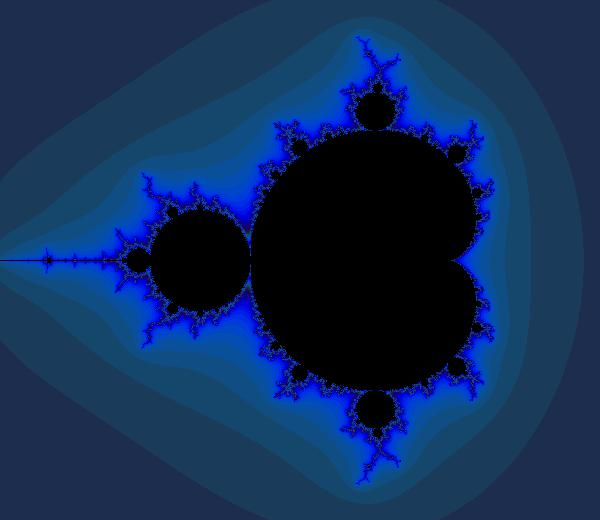

In [6]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np

# Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import Image, display

def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

sess = tf.InteractiveSession()

# Use NumPy to create a 2D array of complex numbers

Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
Z = X+1j*Y

xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))

tf.global_variables_initializer().run()

# Compute the new values of z: z^2 + x
zs_ = zs*zs + xs

# Have we diverged with this new value?
not_diverged = tf.abs(zs_) < 4

step = tf.group(
  zs.assign(zs_),
  ns.assign_add(tf.cast(not_diverged, tf.float32))
  )

for i in range(200): step.run()
    
DisplayFractal(ns.eval())

# Helpful Functions for Keras and TensorFlow

In [7]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Classification

In [8]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Using TensorFlow backend.


Train on 150 samples, validate on 38 samples
Epoch 1/1000
 - 0s - loss: 1.0977 - val_loss: 1.0969
Epoch 2/1000
 - 0s - loss: 1.0962 - val_loss: 1.0958
Epoch 3/1000
 - 0s - loss: 1.0948 - val_loss: 1.0943
Epoch 4/1000
 - 0s - loss: 1.0934 - val_loss: 1.0929
Epoch 5/1000
 - 0s - loss: 1.0917 - val_loss: 1.0913
Epoch 6/1000
 - 0s - loss: 1.0901 - val_loss: 1.0896
Epoch 7/1000
 - 0s - loss: 1.0881 - val_loss: 1.0877
Epoch 8/1000
 - 0s - loss: 1.0863 - val_loss: 1.0857
Epoch 9/1000
 - 0s - loss: 1.0838 - val_loss: 1.0834
Epoch 10/1000
 - 0s - loss: 1.0814 - val_loss: 1.0809
Epoch 11/1000
 - 0s - loss: 1.0789 - val_loss: 1.0781
Epoch 12/1000
 - 0s - loss: 1.0758 - val_loss: 1.0750
Epoch 13/1000
 - 0s - loss: 1.0726 - val_loss: 1.0716
Epoch 14/1000
 - 0s - loss: 1.0689 - val_loss: 1.0678
Epoch 15/1000
 - 0s - loss: 1.0651 - val_loss: 1.0636
Epoch 16/1000
 - 0s - loss: 1.0608 - val_loss: 1.0592
Epoch 17/1000
 - 0s - loss: 1.0564 - val_loss: 1.0546
Epoch 18/1000
 - 0s - loss: 1.0517 - val_loss:

 - 0s - loss: 0.3211 - val_loss: 0.2807
Epoch 152/1000
 - 0s - loss: 0.3193 - val_loss: 0.2794
Epoch 153/1000
 - 0s - loss: 0.3180 - val_loss: 0.2779
Epoch 154/1000
 - 0s - loss: 0.3165 - val_loss: 0.2767
Epoch 155/1000
 - 0s - loss: 0.3154 - val_loss: 0.2755
Epoch 156/1000
 - 0s - loss: 0.3139 - val_loss: 0.2742
Epoch 157/1000
 - 0s - loss: 0.3125 - val_loss: 0.2730
Epoch 158/1000
 - 0s - loss: 0.3112 - val_loss: 0.2719
Epoch 159/1000
 - 0s - loss: 0.3098 - val_loss: 0.2706
Epoch 160/1000
 - 0s - loss: 0.3089 - val_loss: 0.2696
Epoch 161/1000
 - 0s - loss: 0.3073 - val_loss: 0.2682
Epoch 162/1000
 - 0s - loss: 0.3060 - val_loss: 0.2669
Epoch 163/1000
 - 0s - loss: 0.3046 - val_loss: 0.2657
Epoch 164/1000
 - 0s - loss: 0.3035 - val_loss: 0.2645
Epoch 165/1000
 - 0s - loss: 0.3022 - val_loss: 0.2633
Epoch 166/1000
 - 0s - loss: 0.3007 - val_loss: 0.2623
Epoch 167/1000
 - 0s - loss: 0.2998 - val_loss: 0.2614
Epoch 168/1000
 - 0s - loss: 0.2985 - val_loss: 0.2598
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.1780 - val_loss: 0.1491
Epoch 301/1000
 - 0s - loss: 0.1774 - val_loss: 0.1486
Epoch 302/1000
 - 0s - loss: 0.1768 - val_loss: 0.1482
Epoch 303/1000
 - 0s - loss: 0.1762 - val_loss: 0.1474
Epoch 304/1000
 - 0s - loss: 0.1756 - val_loss: 0.1468
Epoch 305/1000
 - 0s - loss: 0.1750 - val_loss: 0.1463
Epoch 306/1000
 - 0s - loss: 0.1743 - val_loss: 0.1458
Epoch 307/1000
 - 0s - loss: 0.1738 - val_loss: 0.1453
Epoch 308/1000
 - 0s - loss: 0.1733 - val_loss: 0.1449
Epoch 309/1000
 - 0s - loss: 0.1729 - val_loss: 0.1442
Epoch 310/1000
 - 0s - loss: 0.1722 - val_loss: 0.1438
Epoch 311/1000
 - 0s - loss: 0.1717 - val_loss: 0.1433
Epoch 312/1000
 - 0s - loss: 0.1708 - val_loss: 0.1426
Epoch 313/1000
 - 0s - loss: 0.1703 - val_loss: 0.1420
Epoch 314/1000
 - 0s - loss: 0.1701 - val_loss: 0.1415
Epoch 315/1000
 - 0s - loss: 0.1694 - val_loss: 0.1412
Epoch 316/1000
 - 0s - loss: 0.1686 - val_loss: 0.1408
Epoch 317/1000
 - 0s - loss: 0.1681 - val_loss: 0.1403
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.1158 - val_loss: 0.0926
Epoch 450/1000
 - 0s - loss: 0.1157 - val_loss: 0.0924
Epoch 451/1000
 - 0s - loss: 0.1160 - val_loss: 0.0921
Epoch 452/1000
 - 0s - loss: 0.1151 - val_loss: 0.0919
Epoch 453/1000
 - 0s - loss: 0.1151 - val_loss: 0.0916
Epoch 454/1000
 - 0s - loss: 0.1146 - val_loss: 0.0914
Epoch 455/1000
 - 0s - loss: 0.1149 - val_loss: 0.0912
Epoch 456/1000
 - 0s - loss: 0.1142 - val_loss: 0.0909
Epoch 457/1000
 - 0s - loss: 0.1138 - val_loss: 0.0907
Epoch 458/1000
 - 0s - loss: 0.1144 - val_loss: 0.0904
Epoch 459/1000
 - 0s - loss: 0.1142 - val_loss: 0.0904
Epoch 460/1000
 - 0s - loss: 0.1132 - val_loss: 0.0900
Epoch 461/1000
 - 0s - loss: 0.1127 - val_loss: 0.0897
Epoch 462/1000
 - 0s - loss: 0.1129 - val_loss: 0.0896
Epoch 463/1000
 - 0s - loss: 0.1123 - val_loss: 0.0892
Epoch 464/1000
 - 0s - loss: 0.1125 - val_loss: 0.0891
Epoch 465/1000
 - 0s - loss: 0.1121 - val_loss: 0.0888
Epoch 466/1000
 - 0s - loss: 0.1116 - val_loss: 0.0885
Epoch 467/1000
 - 0s - lo

In [9]:
from sklearn import metrics
import tensorflow as tf

# Evaluate success using accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9736842105263158


# Regression

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 398 samples, validate on 100 samples
Epoch 1/1000
 - 0s - loss: 202.9356 - val_loss: 162.2059
Epoch 2/1000
 - 0s - loss: 196.4234 - val_loss: 155.3486
Epoch 3/1000
 - 0s - loss: 190.2756 - val_loss: 152.1142
Epoch 4/1000
 - 0s - loss: 186.0654 - val_loss: 149.0562
Epoch 5/1000
 - 0s - loss: 182.1500 - val_loss: 145.9889
Epoch 6/1000
 - 0s - loss: 178.6752 - val_loss: 142.4402
Epoch 7/1000
 - 0s - loss: 174.1663 - val_loss: 138.4613
Epoch 8/1000
 - 0s - loss: 168.8418 - val_loss: 133.9466
Epoch 9/1000
 - 0s - loss: 163.2540 - val_loss: 128.2846
Epoch 10/1000
 - 0s - loss: 156.0814 - val_loss: 121.5294
Epoch 11/1000
 - 0s - loss: 147.0334 - val_loss: 113.4802
Epoch 12/1000
 - 0s - loss: 136.8134 - val_loss: 105.1051
Epoch 13/1000
 - 0s - loss: 127.1508 - val_loss: 94.1945
Epoch 14/1000
 - 0s - loss: 116.0366 - val_loss: 85.4573
Epoch 15/1000
 - 0s - loss: 107.5330 - val_loss: 76.3530
Epoch 16/1000
 - 0s - loss: 92.2230 - val_loss: 65.5397
Epoch 17/1000
 - 0s - loss: 80.3028 - va

In [11]:
# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (RMSE): {}".format(np.sqrt(score)))

Final score (RMSE): 3.282334566116333


# LSTM

In [12]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import numpy as np

max_features = 4 # 0,1,2,3 (total of 4)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

# Convert y2 to dummy variables
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
print(y2)

print('Build model...')
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_dim=1))
model.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x,y2,epochs=200)
pred = model.predict(x)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected classes: {}",predict_classes)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
Build model...


/Users/jheaton/miniconda3/envs/rga/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/jheaton/miniconda3/envs/rga/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1))`


Train...
Epoch 1/200
6/6 [==============================] - 1s 147ms/step - loss: 0.7001 - acc: 0.5417
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6948 - acc: 0.5417
Epoch 3/200
6/6 [==============================] - 0s 1ms/step - loss: 0.6890 - acc: 0.7083
Epoch 4/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6846 - acc: 0.7500
Epoch 5/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6712 - acc: 0.7500
Epoch 6/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6672 - acc: 0.7500
Epoch 7/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6615 - acc: 0.7917
Epoch 8/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6596 - acc: 0.7917
Epoch 9/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6512 - acc: 0.7500
Epoch 10/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6339 - acc: 0.7917
Epoch 11/200
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 1ms/step - loss: 0.4310 - acc: 0.8333
Epoch 90/200
6/6 [==============================] - 0s 1ms/step - loss: 0.4721 - acc: 0.7917
Epoch 91/200
6/6 [==============================] - 0s 1ms/step - loss: 0.3942 - acc: 0.8333
Epoch 92/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2539 - acc: 0.9167
Epoch 93/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2804 - acc: 0.9583
Epoch 94/200
6/6 [==============================] - 0s 1ms/step - loss: 0.4010 - acc: 0.8333
Epoch 95/200
6/6 [==============================] - 0s 1ms/step - loss: 0.5016 - acc: 0.7500
Epoch 96/200
6/6 [==============================] - 0s 1ms/step - loss: 0.3385 - acc: 0.8333
Epoch 97/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2800 - acc: 0.8750
Epoch 98/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2756 - acc: 0.9167
Epoch 99/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2696 - ac

Epoch 177/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2757 - acc: 0.9167
Epoch 178/200
6/6 [==============================] - 0s 1ms/step - loss: 0.5533 - acc: 0.7500
Epoch 179/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2765 - acc: 0.8750
Epoch 180/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1300 - acc: 1.0000
Epoch 181/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1636 - acc: 1.0000
Epoch 182/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2425 - acc: 0.8750
Epoch 183/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2069 - acc: 0.9167
Epoch 184/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1323 - acc: 1.0000
Epoch 185/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2527 - acc: 0.9167
Epoch 186/200
6/6 [==============================] - 0s 1ms/step - loss: 0.3874 - acc: 0.8333
Epoch 187/200
6/6 [==============================] - 0s 2ms/

In [13]:
def runit(model, inp):
    inp = np.array(inp,dtype=np.float32)
    pred = model.predict(inp)
    return np.argmax(pred[0])

print( runit( model, [[[0],[0],[0],[0],[3],[3]]] ))

3
